In [44]:
optim = require 'optim'
fullset = torch.load('newdata20.dat')

In [45]:
itorch.image(fullset.data[1])
print(fullset.label[1])

111	


In [46]:
shuffle = torch.randperm(fullset.size)
shuffleset = fullset
for i=1, fullset.size do
    shuffleset.data[i] = fullset.data[shuffle[i]]
    shuffleset.label[i] = fullset.label[shuffle[i]]
    end
fullset = shuffleset

In [47]:
fullset

{
  data : DoubleTensor - size: 40134x20x20
  size : 40121
  label : DoubleTensor - size: 40134
}


In [48]:
for i=1,fullset.size do
    if(fullset.label[i]<=57) then
        fullset.label[i]=fullset.label[i]-47
    else
        fullset.label[i]=fullset.label[i]-97+11;
    end
end

In [49]:
trainset = {
    size = 32000,
    data = fullset.data[{{1,32000}}]:double(),
    label = fullset.label[{{1,32000}}]
}

In [50]:
validationset = {
    size = 2159,
    data = fullset.data[{{32001,34159}}]:double(),
    label = fullset.label[{{32001,34159}}]
}

In [51]:
itorch.image(trainset.data[1])
print(trainset.label[1])

4	


In [52]:
testset = {
    size = 2000,
    data = fullset.data[{{34160,36159}}]:double(),
    label = fullset.label[{{34160,36159}}]
}

In [53]:
--[[nn = require 'nn'
model = nn.Sequential()
model:add(nn.SpatialConvolution(1, 6, 3, 3))
--net:add(nn.ReLU())                       -- non-linearity 
model:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
model:add(nn.View(6*9*9))--]]  
nn = require 'nn'
model = nn.Sequential()
model:add(nn.Reshape(400))

In [54]:
--[[model:add(nn.Linear(400, 120))             -- fully connected layer (matrix multiplication between input and weights)
model:add(nn.Tanh())                       -- non-linearity 
model:add(nn.Linear(120, 36))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
model:add(nn.LogSoftMax())--]]                    -- converts the output to a log-probability. Useful for classification problems

model:add(nn.Linear(400,700))
model:add(nn.Tanh())
--model:add(nn.Linear(174,131))
--model:add(nn.Tanh())
model:add(nn.Linear(700,36))
model:add(nn.LogSoftMax())

In [55]:
--model=torch.load('oldmodel.net')
criterion = nn.ClassNLLCriterion()

In [56]:
sgd_params = {
   learningRate = 1e-2,
   learningRateDecay = 1e-4,
   weightDecay = 1e-3,
   momentum = 1e-4
}

In [57]:
x, dl_dx = model:getParameters()

In [58]:
step = function(batch_size)
    local current_loss = 0
    local count = 0
    batch_size = batch_size or 200
    for t = 1, trainset.size, batch_size do
        local size = math.min(t + batch_size -1, trainset.size) - t
        local inputs = torch.Tensor(size, 20, 20)
        local targets = torch.Tensor(size)
        for i = 1,size do
            local input = trainset.data[i+t]
            local target = trainset.label[i+t]
            -- if target == 0 then target = 10 end
            inputs[i] = input
            targets[i] = target
        end
        
        local feval = function(x_new)
            -- reset data
            if x ~= x_new then x:copy(x_new) end
            dl_dx:zero()

            -- perform mini-batch gradient descent
            local loss = criterion:forward(model:forward(inputs), targets)
            model:backward(inputs, criterion:backward(model.output, targets))

            return loss, dl_dx
        end
        
        _, fs = optim.sgd(feval, x, sgd_params)
        -- fs is a table containing value of the loss function
        -- (just 1 value for the SGD optimization)
        count = count + 1
        current_loss = current_loss + fs[1]
    end

    -- normalize loss
    return current_loss / count
end

In [59]:
eval = function(dataset, batch_size)
    local count = 0
    batch_size = batch_size or 200
    
    for i = 1,dataset.size,batch_size do
        local size = math.min(i + batch_size - 1, dataset.size) - i
        local inputs = dataset.data[{{i,i+size-1}}]
        local targets = dataset.label[{{i,i+size-1}}]:long()
        local outputs = model:forward(inputs)
        local _, indices = torch.max(outputs, 2)
        local guessed_right = indices:eq(targets):sum()
        count = count + guessed_right
    end

    return count / dataset.size
end

In [62]:
max_iters = 150

In [63]:
do
    local Plot = require 'itorch.Plot'
    local last_accuracy = 0
    local decreasing = 0
    local loss={}
    local x={}
    local accuracy={}
    local threshold = 1 -- how many deacreasing epochs we allow
    for i = 1,max_iters do
        x[i]=i
        loss[i]=step()
        print(string.format('Epoch: %d Current loss: %4f', i, loss[i]))
        accuracy[i] =eval(validationset)
        print(string.format('Accuracy on the validation set: %4f', accuracy[i]))
               
        --[[if accuracy[i] < last_accuracy then
            if decreasing > threshold then break end
            decreasing = decreasing + 1
        else
            decreasing = 0
        end
        last_accuracy = accuracy[i]--]]
    end
    plot = Plot():circle(x, loss,'red','loss'):legend(true):title('Loss'):draw()
    plot1 = Plot():circle(x, accuracy,'green','accuracy'):legend(true):title('Accuacy'):draw()
    plot = Plot():line(x, loss,'red','loss'):legend(true):title('Loss'):draw()
    plot1 = Plot():line(x, accuracy,'green','accuracy'):legend(true):title('Accuacy'):draw()
end

Epoch: 1 Current loss: 1.041523	


Accuracy on the validation set: 0.731357	


Epoch: 2 Current loss: 0.983621	


Accuracy on the validation set: 0.736452	


Epoch: 3 Current loss: 0.939734	

Accuracy on the validation set: 0.748031	


Epoch: 4 Current loss: 0.926402	


Accuracy on the validation set: 0.746179	


Epoch: 5 Current loss: 0.891398	


Accuracy on the validation set: 0.762853	


Epoch: 6 Current loss: 0.866279	


Accuracy on the validation set: 0.748495	


Epoch: 7 Current loss: 0.846858	


Accuracy on the validation set: 0.764243	


Epoch: 8 Current loss: 0.832873	


Accuracy on the validation set: 0.759611	


Epoch: 9 Current loss: 0.817284	


Accuracy on the validation set: 0.779064	


Epoch: 10 Current loss: 0.801005	


Accuracy on the validation set: 0.787865	


Epoch: 11 Current loss: 0.790094	


Accuracy on the validation set: 0.792033	


Epoch: 12 Current loss: 0.774058	


Accuracy on the validation set: 0.787865	


Epoch: 13 Current loss: 0.766008	


Accuracy on the validation set: 0.784159	


Epoch: 14 Current loss: 0.750655	


Accuracy on the validation set: 0.790181	


Epoch: 15 Current loss: 0.742111	


Accuracy on the validation set: 0.787865	


Epoch: 16 Current loss: 0.724826	


Accuracy on the validation set: 0.792033	


Epoch: 17 Current loss: 0.714448	


Accuracy on the validation set: 0.801297	


Epoch: 18 Current loss: 0.718719	


Accuracy on the validation set: 0.798981	


Epoch: 19 Current loss: 0.716334	


Accuracy on the validation set: 0.805465	


Epoch: 20 Current loss: 0.719572	


Accuracy on the validation set: 0.797591	


Epoch: 21 Current loss: 0.716019	


Accuracy on the validation set: 0.812413	


Epoch: 22 Current loss: 0.705475	


Accuracy on the validation set: 0.792960	


Epoch: 23 Current loss: 0.687019	


Accuracy on the validation set: 0.798055	


Epoch: 24 Current loss: 0.675832	


Accuracy on the validation set: 0.800371	


Epoch: 25 Current loss: 0.682097	


Accuracy on the validation set: 0.802223	


Epoch: 26 Current loss: 0.670654	


Accuracy on the validation set: 0.803613	


Epoch: 27 Current loss: 0.677101	


Accuracy on the validation set: 0.809634	


Epoch: 28 Current loss: 0.659716	


Accuracy on the validation set: 0.816582	


Epoch: 29 Current loss: 0.652526	


Accuracy on the validation set: 0.811950	


Epoch: 30 Current loss: 0.641390	


Accuracy on the validation set: 0.810097	


Epoch: 31 Current loss: 0.650993	


Accuracy on the validation set: 0.812876	


Epoch: 32 Current loss: 0.650933	


Accuracy on the validation set: 0.823066	


Epoch: 33 Current loss: 0.633980	


Accuracy on the validation set: 0.823993	


Epoch: 34 Current loss: 0.633781	


Accuracy on the validation set: 0.809634	


Epoch: 35 Current loss: 0.640198	


Accuracy on the validation set: 0.825845	


Epoch: 36 Current loss: 0.630284	


Accuracy on the validation set: 0.817971	


Epoch: 37 Current loss: 0.634187	


Accuracy on the validation set: 0.811487	


Epoch: 38 Current loss: 0.628142	


Accuracy on the validation set: 0.823529	


Epoch: 39 Current loss: 0.616521	


Accuracy on the validation set: 0.826772	


Epoch: 40 Current loss: 0.611016	


Accuracy on the validation set: 0.801297	


Epoch: 41 Current loss: 0.614404	


Accuracy on the validation set: 0.822603	


Epoch: 42 Current loss: 0.608444	


Accuracy on the validation set: 0.815192	


Epoch: 43 Current loss: 0.610639	


Accuracy on the validation set: 0.821214	


Epoch: 44 Current loss: 0.602874	


Accuracy on the validation set: 0.827235	


Epoch: 45 Current loss: 0.582966	


Accuracy on the validation set: 0.835572	


Epoch: 46 Current loss: 0.585533	


Accuracy on the validation set: 0.828161	


Epoch: 47 Current loss: 0.575196	


Accuracy on the validation set: 0.824456	


Epoch: 48 Current loss: 0.591967	


Accuracy on the validation set: 0.823993	


Epoch: 49 Current loss: 0.575830	


Accuracy on the validation set: 0.838814	

Epoch: 50 Current loss: 0.584147	


Accuracy on the validation set: 0.830477	


Epoch: 51 Current loss: 0.576521	


Accuracy on the validation set: 0.830477	


Epoch: 52 Current loss: 0.570863	


Accuracy on the validation set: 0.833256	


Epoch: 53 Current loss: 0.569408	


Accuracy on the validation set: 0.835572	


Epoch: 54 Current loss: 0.564372	


Accuracy on the validation set: 0.838351	


Epoch: 55 Current loss: 0.543232	


Accuracy on the validation set: 0.836962	


Epoch: 56 Current loss: 0.554344	


Accuracy on the validation set: 0.837888	


Epoch: 57 Current loss: 0.552854	


Accuracy on the validation set: 0.840667	


Epoch: 58 Current loss: 0.546326	


Accuracy on the validation set: 0.838814	


Epoch: 59 Current loss: 0.544839	


Accuracy on the validation set: 0.849467	


Epoch: 60 Current loss: 0.547733	


Accuracy on the validation set: 0.829088	


Epoch: 61 Current loss: 0.536193	


Accuracy on the validation set: 0.830940	


Epoch: 62 Current loss: 0.543871	


Accuracy on the validation set: 0.837888	


Epoch: 63 Current loss: 0.543081	


Accuracy on the validation set: 0.844372	


Epoch: 64 Current loss: 0.532036	


Accuracy on the validation set: 0.843909	


Epoch: 65 Current loss: 0.523671	


Accuracy on the validation set: 0.847151	


Epoch: 66 Current loss: 0.529944	


Accuracy on the validation set: 0.847151	


Epoch: 67 Current loss: 0.518046	


Accuracy on the validation set: 0.842983	


Epoch: 68 Current loss: 0.523383	


Accuracy on the validation set: 0.846225	


Epoch: 69 Current loss: 0.509581	


Accuracy on the validation set: 0.855489	


Epoch: 70 Current loss: 0.506872	


Accuracy on the validation set: 0.846688	


Epoch: 71 Current loss: 0.519017	


Accuracy on the validation set: 0.845762	


Epoch: 72 Current loss: 0.520299	


Accuracy on the validation set: 0.850857	


Epoch: 73 Current loss: 0.525645	


Accuracy on the validation set: 0.845762	


Epoch: 74 Current loss: 0.515172	


Accuracy on the validation set: 0.849004	


Epoch: 75 Current loss: 0.512280	


Accuracy on the validation set: 0.854099	


Epoch: 76 Current loss: 0.497226	


Accuracy on the validation set: 0.848078	


Epoch: 77 Current loss: 0.489254	


Accuracy on the validation set: 0.846688	


Epoch: 78 Current loss: 0.484403	


Accuracy on the validation set: 0.859657	


Epoch: 79 Current loss: 0.492390	


Accuracy on the validation set: 0.858731	


Epoch: 80 Current loss: 0.478049	


Accuracy on the validation set: 0.871237	


Epoch: 81 Current loss: 0.476727	


Accuracy on the validation set: 0.860120	


Epoch: 82 Current loss: 0.480427	


Accuracy on the validation set: 0.855489	


Epoch: 83 Current loss: 0.480383	


Accuracy on the validation set: 0.860584	


Epoch: 84 Current loss: 0.460779	


Accuracy on the validation set: 0.857341	


Epoch: 85 Current loss: 0.473777	


Accuracy on the validation set: 0.860584	


Epoch: 86 Current loss: 0.470677	


Accuracy on the validation set: 0.860120	


Epoch: 87 Current loss: 0.468673	


Accuracy on the validation set: 0.862436	


Epoch: 88 Current loss: 0.465176	


Accuracy on the validation set: 0.855489	


Epoch: 89 Current loss: 0.470785	


Accuracy on the validation set: 0.870310	


Epoch: 90 Current loss: 0.459882	


Accuracy on the validation set: 0.858268	


Epoch: 91 Current loss: 0.470750	


Accuracy on the validation set: 0.858268	


Epoch: 92 Current loss: 0.471661	


Accuracy on the validation set: 0.864289	


Epoch: 93 Current loss: 0.464049	


Accuracy on the validation set: 0.866605	


Epoch: 94 Current loss: 0.455683	


Accuracy on the validation set: 0.862436	


Epoch: 95 Current loss: 0.465863	


Accuracy on the validation set: 0.860120	


Epoch: 96 Current loss: 0.449629	


Accuracy on the validation set: 0.865215	


Epoch: 97 Current loss: 0.446926	


Accuracy on the validation set: 0.865215	


Epoch: 98 Current loss: 0.447272	


Accuracy on the validation set: 0.868921	


Epoch: 99 Current loss: 0.453363	


Accuracy on the validation set: 0.872626	


Epoch: 100 Current loss: 0.456317	


Accuracy on the validation set: 0.868921	


Epoch: 101 Current loss: 0.448451	


Accuracy on the validation set: 0.857341	


Epoch: 102 Current loss: 0.444231	


Accuracy on the validation set: 0.874479	


Epoch: 103 Current loss: 0.447400	


Accuracy on the validation set: 0.855025	


Epoch: 104 Current loss: 0.441486	


Accuracy on the validation set: 0.875868	


Epoch: 105 Current loss: 0.446496	


Accuracy on the validation set: 0.865215	


Epoch: 106 Current loss: 0.445502	


Accuracy on the validation set: 0.869847	


Epoch: 107 Current loss: 0.443427	


Accuracy on the validation set: 0.866142	


Epoch: 108 Current loss: 0.448408	


Accuracy on the validation set: 0.865215	


Epoch: 109 Current loss: 0.444144	


Accuracy on the validation set: 0.871237	


Epoch: 110 Current loss: 0.430923	


Accuracy on the validation set: 0.865679	


Epoch: 111 Current loss: 0.432840	


Accuracy on the validation set: 0.866605	


Epoch: 112 Current loss: 0.419908	


Accuracy on the validation set: 0.871237	


Epoch: 113 Current loss: 0.432865	


Accuracy on the validation set: 0.874479	


Epoch: 114 Current loss: 0.421449	


Accuracy on the validation set: 0.869847	


Epoch: 115 Current loss: 0.411625	


Accuracy on the validation set: 0.877721	


Epoch: 116 Current loss: 0.412931	


Accuracy on the validation set: 0.875405	


Epoch: 117 Current loss: 0.410349	


Accuracy on the validation set: 0.874942	


Epoch: 118 Current loss: 0.409268	


Accuracy on the validation set: 0.874942	


Epoch: 119 Current loss: 0.412809	


Accuracy on the validation set: 0.879574	


Epoch: 120 Current loss: 0.410559	


Accuracy on the validation set: 0.870774	


Epoch: 121 Current loss: 0.405804	


Accuracy on the validation set: 0.882353	


Epoch: 122 Current loss: 0.412475	


Accuracy on the validation set: 0.873553	


Epoch: 123 Current loss: 0.408114	


Accuracy on the validation set: 0.872163	


Epoch: 124 Current loss: 0.406748	


Accuracy on the validation set: 0.876795	


Epoch: 125 Current loss: 0.399918	


Accuracy on the validation set: 0.878648	


Epoch: 126 Current loss: 0.392990	


Accuracy on the validation set: 0.876332	


Epoch: 127 Current loss: 0.398736	


Accuracy on the validation set: 0.877721	


Epoch: 128 Current loss: 0.391283	


Accuracy on the validation set: 0.882816	


Epoch: 129 Current loss: 0.391870	


Accuracy on the validation set: 0.880037	


Epoch: 130 Current loss: 0.389432	


Accuracy on the validation set: 0.882353	


Epoch: 131 Current loss: 0.396556	


Accuracy on the validation set: 0.880963	


Epoch: 132 Current loss: 0.397203	


Accuracy on the validation set: 0.870774	


Epoch: 133 Current loss: 0.382209	


Accuracy on the validation set: 0.875405	


Epoch: 134 Current loss: 0.387806	


Accuracy on the validation set: 0.878184	


Epoch: 135 Current loss: 0.379439	


Accuracy on the validation set: 0.878648	


Epoch: 136 Current loss: 0.379655	


Accuracy on the validation set: 0.882816	


Epoch: 137 Current loss: 0.375729	


Accuracy on the validation set: 0.880963	


Epoch: 138 Current loss: 0.367446	


Accuracy on the validation set: 0.891616	


Epoch: 139 Current loss: 0.363828	


Accuracy on the validation set: 0.878184	


Epoch: 140 Current loss: 0.371269	


Accuracy on the validation set: 0.888374	


Epoch: 141 Current loss: 0.365163	


Accuracy on the validation set: 0.888374	


Epoch: 142 Current loss: 0.378533	


Accuracy on the validation set: 0.882353	


Epoch: 143 Current loss: 0.375966	


Accuracy on the validation set: 0.884206	


Epoch: 144 Current loss: 0.367275	


Accuracy on the validation set: 0.881890	


Epoch: 145 Current loss: 0.362690	


Accuracy on the validation set: 0.886522	


Epoch: 146 Current loss: 0.363563	


Accuracy on the validation set: 0.886522	


Epoch: 147 Current loss: 0.362816	


Accuracy on the validation set: 0.888374	


Epoch: 148 Current loss: 0.369812	


Accuracy on the validation set: 0.887911	


Epoch: 149 Current loss: 0.355677	


Accuracy on the validation set: 0.891153	


Epoch: 150 Current loss: 0.352961	


Accuracy on the validation set: 0.892543	


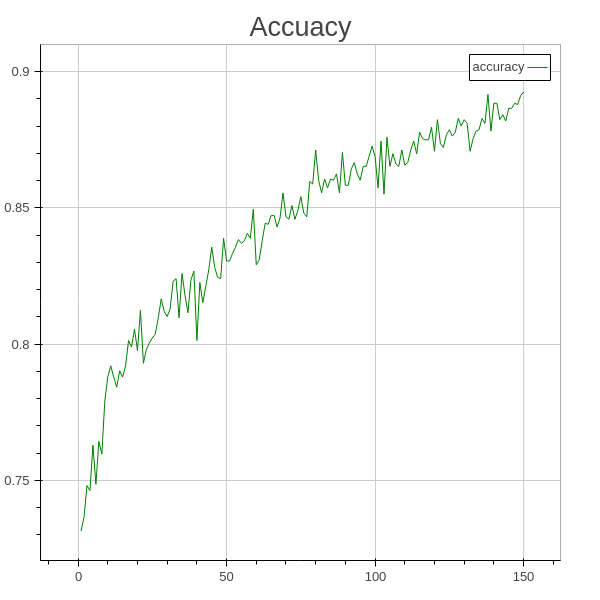

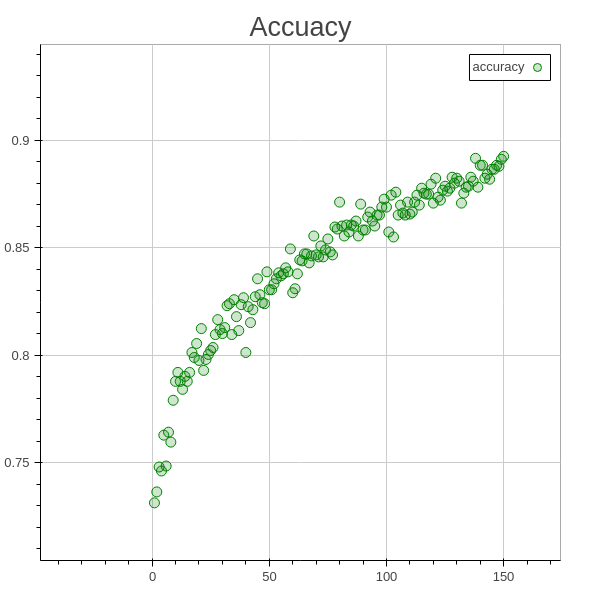

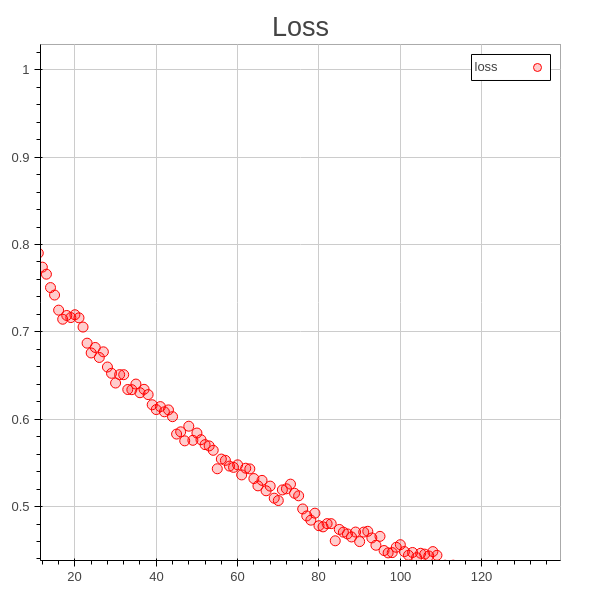

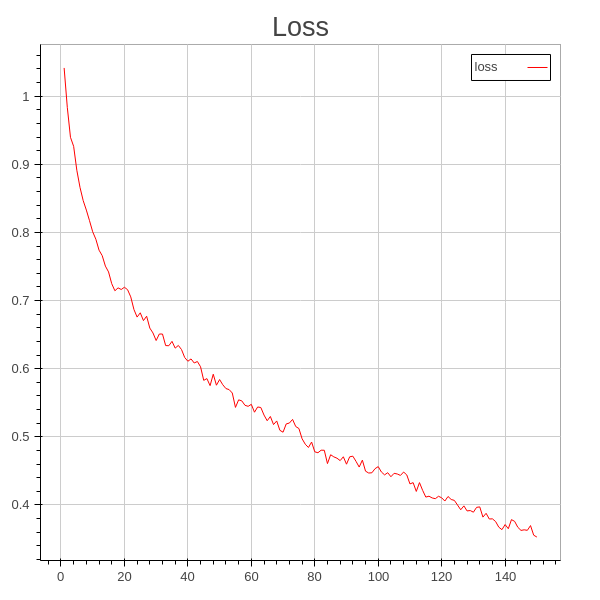

In [65]:
itorch.image("plots/plot1.png")
itorch.image("plots/plot2.png")
itorch.image("plots/plot3.png")
itorch.image("plots/plot4.png")

In [19]:
eval(testset)

0.827	


In [20]:
torch.save('oldmodel.net',model)

In [21]:
plot:save('plot.html')
plot1:save('plot1.html')

In [20]:
eval(trainset)

0.83	


In [21]:
eval(validationset)

0.80824455766559	


In [28]:
a=image.load("r3.png",1,'byte')
--a=testset.data[10]

In [29]:
b=torch.Tensor(1,20,20)
b[1]=image.scale(a,20,20)
itorch.image(b[1])

In [30]:
pred=model:forward(b)
conf, indi=torch.sort(pred, true)
alpha=48
beta=65
gamma=indi[1][1]
if gamma < 11 then
    print(string.char(alpha+gamma-1))
else
    beta=beta+gamma-11
    print(string.char(beta))
end
--t=torch.Int(1):copy(1)
--indi[1]=indi[1]:type('int')
--print (CharTensor:(indi[1]))

R	
